# Итоговый проект: Handwritten text recognition

## Импорт библиотек и перевод вычислений на GPU

In [18]:
import tensorflow as tf
import os
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Input, Concatenate, MaxPooling2D, Dropout, LSTM, \
Bidirectional, Reshape, Dense, Lambda
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras import backend as K
from keras.models import Model
from tensorflow.keras.optimizers import *
from keras.metrics import IoU
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.utils import Sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Разрешить динамическое выделение памяти на GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Извлекаем данные и проверяем на корректность разметку

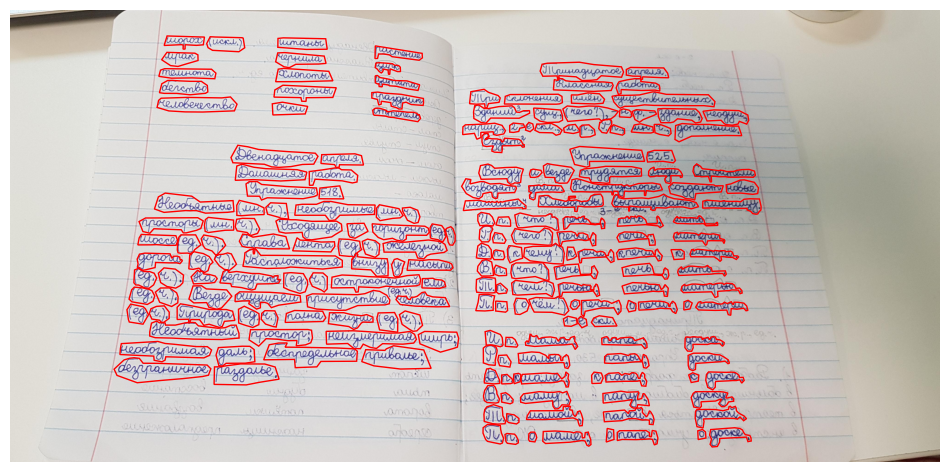

In [2]:
# Путь к JSON и изображениям
json_path = "annotations_train.json"
images_folder = "images/"

# Загрузка аннотаций
with open(json_path, "r", encoding="utf-8") as f:
    annotations_data = json.load(f)
# Парсинг данных
images = {img["id"]: img for img in annotations_data["images"]}
categories = {cat["id"]: cat["name"] for cat in annotations_data["categories"]}
annotations = annotations_data["annotations"]

words = []

def extract_segments(image, annotations):
    """
    Вырезает сегменты из изображения на основе аннотаций.
    
    Args:
        image: PIL.Image.Image объект изображения.
        annotations: Список аннотаций с полигонами.
    
    Returns:
        Список изображений-сегментов.
    """
    segments = []
    image_np = np.array(image)  # Преобразование PIL.Image в NumPy array
    for ann in annotations:
        segmentation = np.array(ann['segmentation'][0], dtype=np.int32).reshape(-1, 2)
        x, y, w, h = cv2.boundingRect(segmentation)  # Ограничивающий прямоугольник
        cropped = image_np[y:y+h, x:x+w]
        
        # Маска для вырезания конкретного сегмента
        mask = np.zeros_like(image_np[:, :, 0])  # Черно-белая маска
        cv2.fillPoly(mask, [segmentation], 255)
        masked_image = cv2.bitwise_and(cropped, cropped, mask=mask[y:y+h, x:x+w])
        
        segments.append(masked_image)
    return segments


# Визуализация аннотаций для одного изображения
def visualize_annotations(image_id):
    image_info = images[image_id]
    image_path = images_folder + image_info["file_name"]
    
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Создаем фигуру
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    
    # Получаем аннотации для изображения
    image_annotations = [ann for ann in annotations if ann["image_id"] == image_id]
    
    # Визуализация многоугольников
    for ann in image_annotations:
        if ann["category_id"] == 0:
            segmentation = ann["segmentation"][0]  # Координаты сегментации
            polygon = np.array(segmentation).reshape(-1, 2)
            category_name = categories[ann["category_id"]]
            
            # Отображаем многоугольник
            patch = patches.Polygon(
                polygon, closed=True, edgecolor="red", linewidth=1, facecolor="none"
            )
            ax.add_patch(patch)
            
            words.append(ann["attributes"]["translation"])
            
        
    plt.axis("off")
    plt.show()

# Пример: визуализация для изображения с ID = 1
visualize_annotations(image_id=1)

(56, 155, 3)
(71, 271, 3)
(66, 219, 3)
(63, 207, 3)
(51, 111, 3)


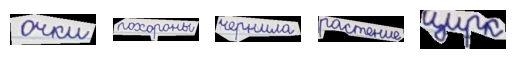

In [3]:
image_id = 1

image_info = images[image_id]
image_path = images_folder + image_info["file_name"]
    
# Загружаем изображение
image = Image.open(image_path)
image_annotations = [ann for ann in annotations if ann["image_id"] == image_id][:5]


segments = extract_segments(image, image_annotations)
for i, segment in enumerate(segments):
    print(segment.shape)
    plt.subplot(1, len(segments), i + 1)
    plt.imshow(segment, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
categories # Будем извлекать только текст учеников

{0: 'pupil_text',
 1: 'pupil_comment',
 2: 'teacher_comment',
 3: 'paper',
 4: 'text_line'}

## Предобработка данных для сегментации

In [5]:
def create_mask(image_shape, annotations):
    """
    Создает бинарную маску из аннотаций.

    Args:
        image_shape: Размер исходного изображения (высота, ширина).
        annotations: Аннотации COCO формата (список словарей).
    
    Returns:
        Маска для данного изображения.
    """
    mask = np.zeros(image_shape[:2], dtype=np.uint8)  # Создаем пустую черно-белую маску
    for ann in annotations:
        segmentation = np.array(ann['segmentation'][0], dtype=np.int32).reshape(-1, 2)
        cv2.fillPoly(mask, [segmentation], 1)  # Заполняем область внутри полигона
    return mask


In [6]:
def resize_image_and_mask(image, mask, target_size=(3000, 4000)):
    """
    Изменяет размер изображения и маски до target_size.

    Args:
        image: Исходное изображение (NumPy массив).
        mask: Бинарная маска.
        target_size: Кортеж (высота, ширина).
    
    Returns:
        Измененные изображение и маска.
    """
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return resized_image, resized_mask


In [7]:
image_id = 1

image_info = images[image_id]
image_path = images_folder + image_info["file_name"]

image_shape = (image_info["height"], image_info["width"])
    
# Загружаем изображение
image = Image.open(image_path)
image_annotations = [ann for ann in annotations if ann["image_id"] == image_id and ann["category_id"] == 0]

mask = create_mask(image_shape, image_annotations)

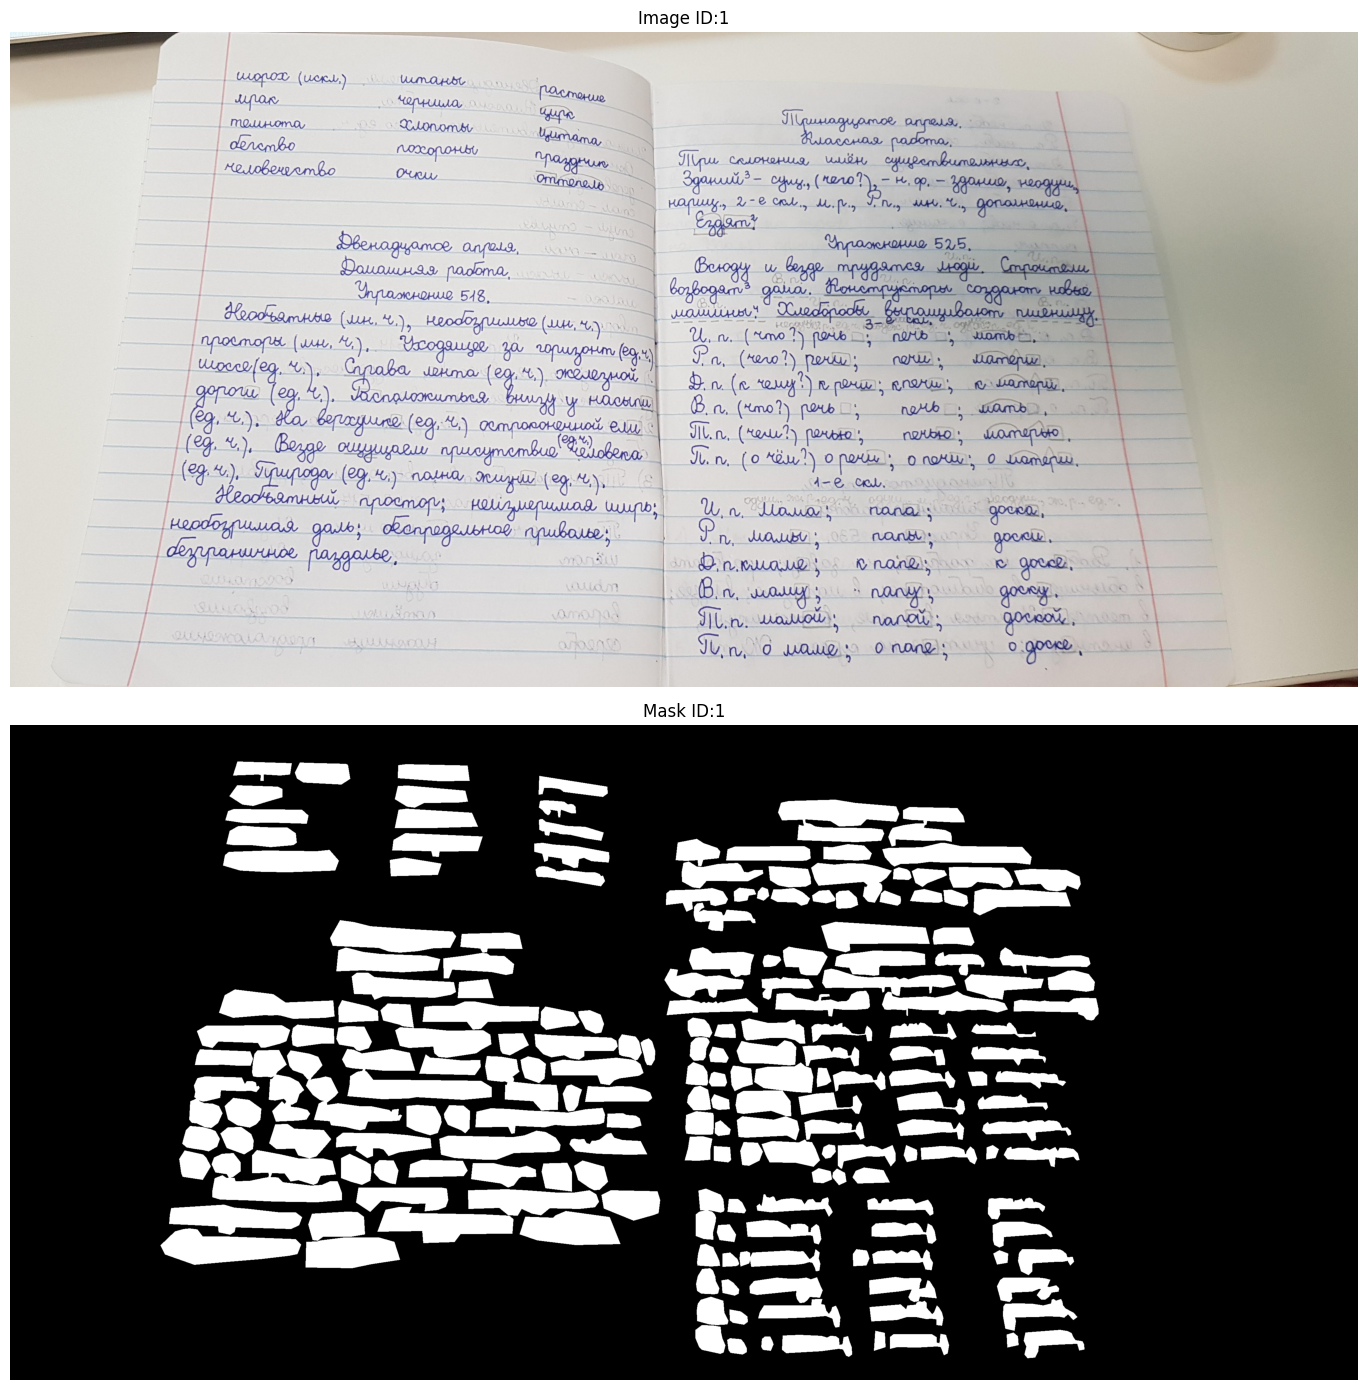

In [8]:
plt.figure(figsize=(14, 14))

# Изображение
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title(f"Image ID:{image_id}")
plt.axis("off")

# Маска
plt.subplot(2, 1, 2)
plt.imshow(mask, cmap='gray')
plt.title(f"Mask ID:{image_id}")
plt.axis("off")

plt.tight_layout()
plt.show()

# Содание тензоров: Изображение - Маска

In [11]:
class ImageMask(Sequence):
    def __init__(self, images, annotations, images_folder, batch_size=8, target_size=(256, 256)):
        """
        Инициализация генератора данных.
        :param images: список информации об изображениях (из annotation["images"]).
        :param annotations: список аннотаций (из annotation["annotations"]).
        :param images_folder: путь к папке с изображениями.
        :param batch_size: размер батча.
        :param target_size: желаемый размер изображений и масок (H, W).
        """
        self.images = images
        self.annotations = annotations
        self.images_folder = images_folder
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []
        
        for image_info in batch_images:
            # Путь к изображению
            image_path = self.images_folder + image_info["file_name"]
            image_shape = (image_info["height"], image_info["width"])
            
            # Загружаем изображение
            image = Image.open(image_path).convert("RGB")
            image = np.array(image) / 255.0  # Нормализация пикселей
            
            # Загружаем аннотации для данного изображения
            image_annotations = [
                ann for ann in self.annotations 
                if ann["image_id"] == image_info["id"] and ann["category_id"] == 0
            ]
            
            # Создаём маску
            mask = create_mask(image_shape, image_annotations)

            image, mask = resize_image_and_mask(image, mask, self.target_size)
            
            images.append(image)
            masks.append(mask)
        
        return np.array(images), np.array(masks)

In [12]:
# Инициализируем DataGenerator
image_mask = ImageMask(
    images=annotations_data["images"], 
    annotations=annotations, 
    images_folder="images/", 
    batch_size=4, 
    target_size=(1024, 1024)
)

x_batch, y_batch = image_mask[0]

print("Shape of X_batch:", x_batch.shape)  # (batch_size, H, W, 3)
print("Shape of y_batch:", y_batch.shape)  # (batch_size, H, W)

Shape of X_batch: (4, 1024, 1024, 3)
Shape of y_batch: (4, 1024, 1024)


In [14]:
json_path = "annotations_val.json"

with open(json_path, "r", encoding="utf-8") as f:
    val_ann_data = json.load(f)

val_image_mask = ImageMask(
    images=val_ann_data["images"],
    annotations=val_ann_data["annotations"],
    images_folder="images/", 
    batch_size=4, 
    target_size=(1024, 1024)
)

x_batch, y_batch = val_image_mask[0]

print("Shape of X_batch:", x_batch.shape)  # (batch_size, H, W, 3)
print("Shape of y_batch:", y_batch.shape)  # (batch_size, H, W)

Shape of X_batch: (4, 1024, 1024, 3)
Shape of y_batch: (4, 1024, 1024)


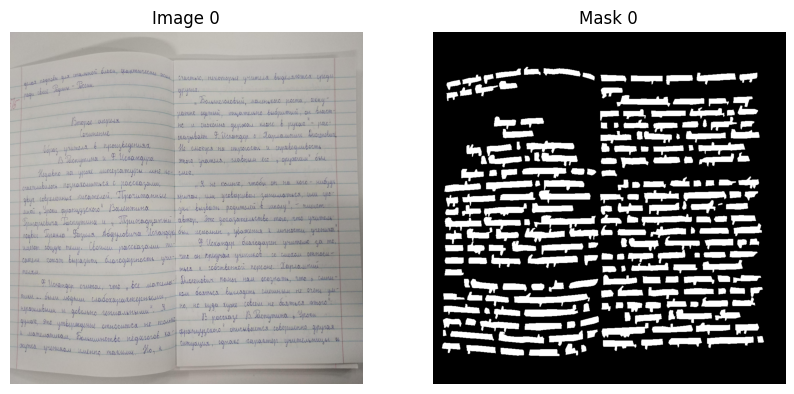

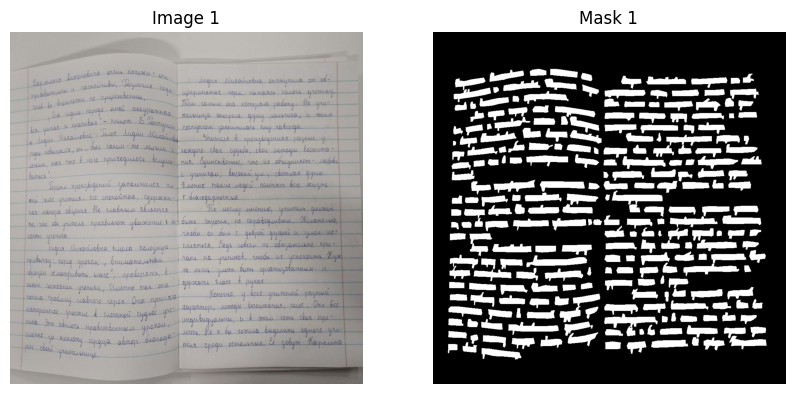

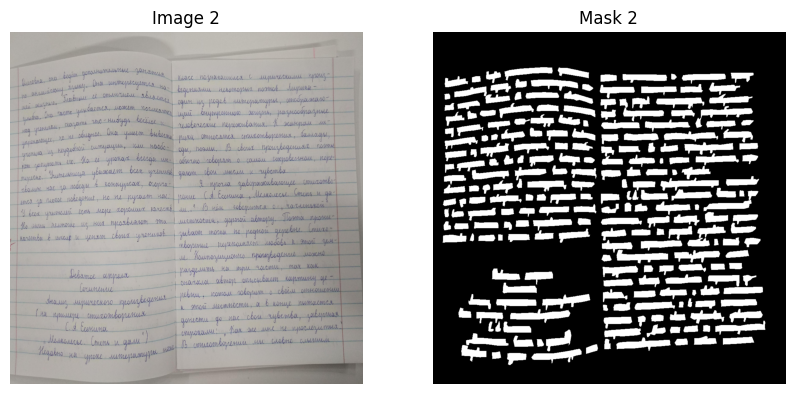

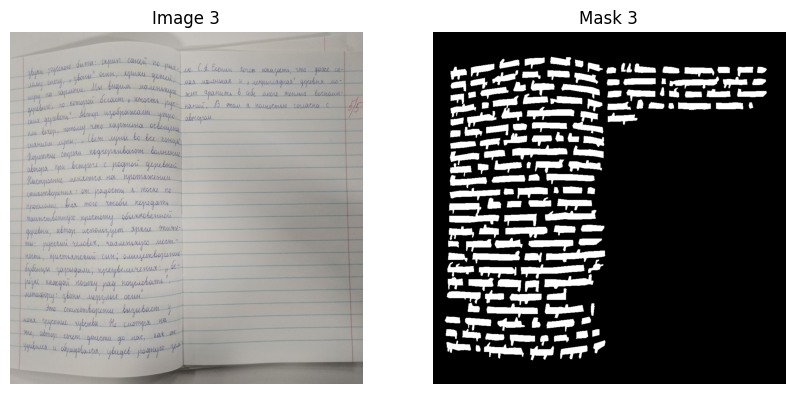

In [15]:
for i in range(min(len(x_batch), 4)):
    plt.figure(figsize=(10, 5))
    
    # Изображение
    plt.subplot(1, 2, 1)
    plt.imshow(x_batch[i], cmap="gray")
    plt.title(f"Image {i}")
    plt.axis("off")
    
    # Маска
    plt.subplot(1, 2, 2)
    plt.imshow(y_batch[i], cmap="gray")
    plt.title(f"Mask {i}")
    plt.axis("off")
    
    plt.show()

## Реализация U-Net + ResNet50V2

### Обучение модели

In [16]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x


def build_unet_resnet_model(input_shape):
    '''Input layer'''
    inputs = Input(input_shape)

    '''Pre-trained ResNet50V2'''
    resnet50 = ResNet50V2(include_top=False, weights="imagenet", input_tensor=inputs)

    for layer in resnet50.layers:
        layer.trainable = False

    '''Skip connections'''
    s1 = inputs # 1024
    s2 = resnet50.get_layer("conv1_conv").output # 512
    s3 = resnet50.get_layer("conv2_block3_1_relu").output # 256
    s4 = resnet50.get_layer("conv3_block4_1_relu").output # 128

    '''Bridge'''
    b1 = resnet50.get_layer("conv4_block6_1_relu").output # 64

    '''Decoder'''
    d1 = decoder_block(b1, s4, 1024) # 128
    d2 = decoder_block(d1, s3, 512) # 256
    d3 = decoder_block(d2, s2, 256) # 512
    d4 = decoder_block(d3, s1, 128) # 1024

    '''Output Layer'''
    outputs = Conv2D(1, 1, padding="same",  activation="sigmoid")(d4) # Только 1 класс - текст

    model = Model(inputs, outputs)

    return model

In [20]:
model = build_unet_resnet_model((1024, 1024, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1030, 1030,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 512, 512, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

In [13]:
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    y_true_f = tf.cast(y_true_f, tf.float16)
    y_pred_f = tf.cast(y_pred_f, tf.float16)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics =["accuracy", IoU(num_classes=2, target_class_ids=[0,1])])

In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='segmentation_model.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
        restore_best_weights=True),
]

In [15]:
with tf.device("CPU:0/"):
    history = model.fit(image_mask, steps_per_epoch=len(image_mask), epochs=50, verbose=1, callbacks=callbacks, 
    validation_data=val_image_mask, validation_steps=len(val_image_mask))

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'model/conv2d_transpose/conv2d_transpose' defined at (most recent call last):
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Руслан\AppData\Local\Temp\ipykernel_17208\4186519454.py", line 2, in <module>
      history = model.fit(image_mask, steps_per_epoch=len(image_mask), epochs=50, verbose=1, callbacks=callbacks,
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model/conv2d_transpose/conv2d_transpose'
Detected at node 'model/conv2d_transpose/conv2d_transpose' defined at (most recent call last):
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Руслан\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Руслан\AppData\Local\Temp\ipykernel_17208\4186519454.py", line 2, in <module>
      history = model.fit(image_mask, steps_per_epoch=len(image_mask), epochs=50, verbose=1, callbacks=callbacks,
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "c:\Users\Руслан\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model/conv2d_transpose/conv2d_transpose'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 64, computed = 128 spatial_dim: 1 input: 256 filter: 2 output: 64 stride: 2 dilation: 1
	 [[{{node model/conv2d_transpose/conv2d_transpose}}]]
	 [[Adam/IdentityN/_662]]
  (1) INVALID_ARGUMENT:  Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 64, computed = 128 spatial_dim: 1 input: 256 filter: 2 output: 64 stride: 2 dilation: 1
	 [[{{node model/conv2d_transpose/conv2d_transpose}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10119]

In [14]:
model.save("segmentation_resnet_unet_model.weights.h5")

### Проверка сохраненённых весов

In [8]:
second_model = build_unet_resnet_model((1024, 1024, 3))

In [9]:
second_model.load_weights("segmentation_resnet_unet_model.weights.h5")

### Тестирование модели

In [10]:
json_path = "annotations_test.json"

with open(json_path, "r", encoding="utf-8") as f:
    test_ann_data = json.load(f)

test_image_mask = ImageMask(
    images=test_ann_data["images"],
    annotations=test_ann_data["annotations"],
    images_folder="images/", 
    batch_size=5, 
    target_size=(1024, 1024)
)

In [11]:
x_test, y_test = test_image_mask[0]

In [12]:
x_pred = second_model.predict(x_test)

1/1 [==============================] - 6s 6s/step


In [13]:
threshold = 0.5
binary_prediction = (x_pred >= threshold).astype(np.uint8).squeeze()

In [17]:
y_true = y_test.flatten()
y_pred = binary_prediction.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Точность: {accuracy:.2f}")
print(f"Полнота: {recall:.2f}")
print(f"Точность: {precision:.2f}")
print(f"F1-мера: {f1:.2f}")

Точность: 0.95
Полнота: 0.97
Точность: 0.86
F1-мера: 0.91


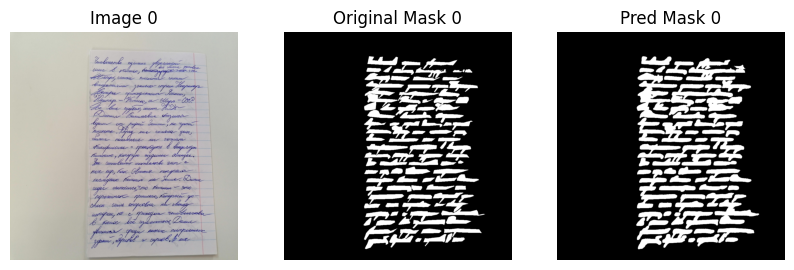

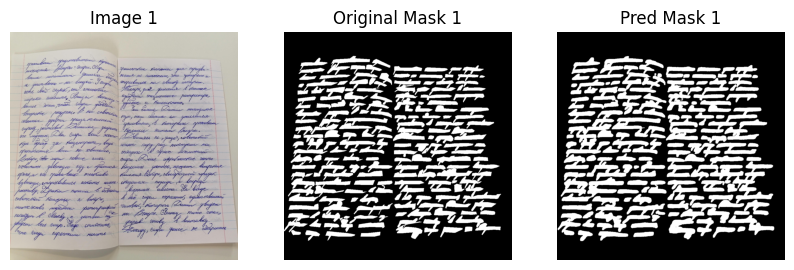

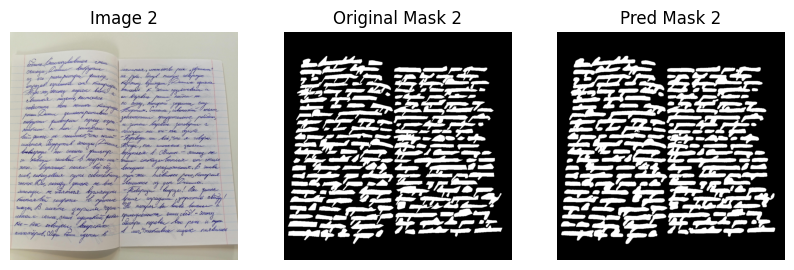

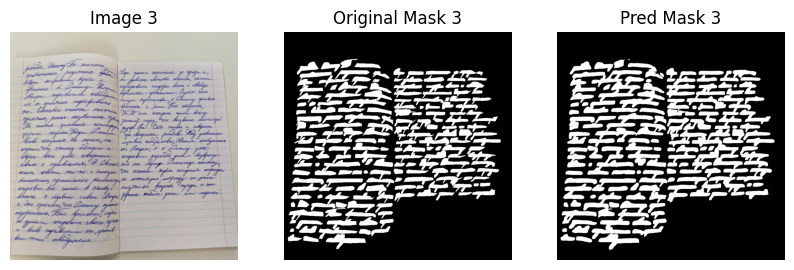

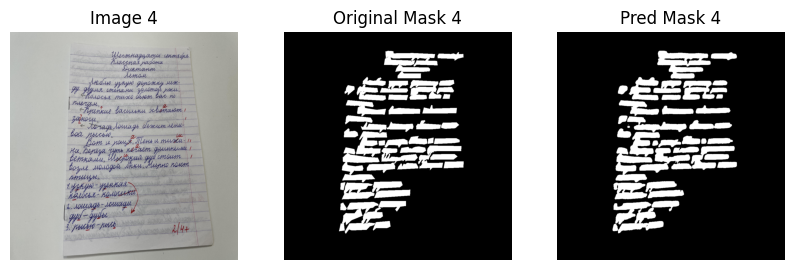

In [18]:
for i in range(len(x_test)):
    plt.figure(figsize=(10, 5))
    
    # Изображение
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i])
    plt.title(f"Image {i}")
    plt.axis("off")
    
    # Маска
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i], cmap="gray")
    plt.title(f"Original Mask {i}")
    plt.axis("off")

    # Маска
    plt.subplot(1, 3, 3)
    plt.imshow(binary_prediction[i], cmap="gray")
    plt.title(f"Pred Mask {i}")
    plt.axis("off")
    
    plt.show()

## HTR Model (C-RNN) Реализация

### Формирование датасета для модели

In [9]:
def extract_text_regions_for_all_images(coco_annotations, images_folder, output_dir):
    """
    Вырезает текстовые регионы из всех изображений в COCO-аннотациях.

    Args:
        coco_annotations: JSON-данные COCO (словарь с ключами "images" и "annotations").
        images_folder: Папка с исходными изображениями.
        output_dir: Директория для сохранения вырезанных областей.
    
    Returns:
        DataFrame с информацией о вырезанных областях.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Загружаем список изображений и аннотаций
    images = {img["id"]: img["file_name"] for img in coco_annotations["images"]}
    annotations = coco_annotations["annotations"]

    dataset = []

    # Проходим по всем изображениям
    for image_info in tqdm(coco_annotations["images"]):
        try:
            image_id = image_info["id"]
            image_annotations = [
                ann for ann in annotations
                if ann["image_id"] == image_id and ann["category_id"] == 0  # Фильтрация по категории (если нужно)
            ]

            if not image_annotations:
                continue  # Если нет аннотаций для изображения, пропускаем

            image_path = os.path.join(images_folder, image_info["file_name"])
            if not os.path.exists(image_path):
                print(f"⚠ Пропущено: {image_path} не найдено")
                continue
            
            image = cv2.imread(image_path)
            if image is None:
                print(f"⚠ Ошибка загрузки: {image_path}")
                continue

            # Проходим по всем аннотациям для текущего изображения
            for index, ann in enumerate(image_annotations):
                # Получаем координаты региона
                segmentation = np.array(ann['segmentation'][0], dtype=np.int32).reshape(-1, 2)
                
                # Вычисляем ограничивающий прямоугольник
                x, y, w, h = cv2.boundingRect(segmentation)
                cropped = image[y:y+h, x:x+w]  # Вырезаем область

                # Делаем черно-белым
                cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

                # Сохраняем
                file_name = f"{image_id}_region_{index}.jpg"
                file_path = os.path.join(output_dir, file_name)
                Image.fromarray(cropped_gray).save(file_path)

                # Добавляем в датасет
                dataset.append({"file_name": file_name, "translation": ann.get("attributes", {}).get("translation", "")})
        
        except:
            continue

    return pd.DataFrame(dataset)


In [10]:
coco_annotations_path = "annotations_train.json"  # Ваш COCO JSON
images_folder = "images/"  # Папка с изображениями
output_dir = "dataset/"  # Куда сохранять

# Загружаем аннотации
with open(coco_annotations_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

# Генерируем датасет
df = extract_text_regions_for_all_images(coco_data, images_folder, output_dir)

# Сохраняем метки в CSV
df.to_csv(os.path.join(output_dir, "labels.csv"), index=False)

print("Датасет успешно создан!")

100%|██████████| 1557/1557 [35:15<00:00,  1.36s/it] 


✅ Датасет успешно создан для всех изображений!


In [3]:
df = pd.read_csv("dataset/labels.csv")

### Формирование списка символов

<i>Позже я просто скопировал полученный список символов для удобства и исключения перетасовки</i>

In [4]:
symbols = set(df["translation"].to_string())
alphabets = set(" 0123456789:;?[]«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё")
alphabets = "".join(list(alphabets | symbols))

In [5]:
alphabets = 'KКПu}ЗR<лLC4Gm:O28БbЕЧя-fИНЭ’зiЮнВpьЩпгШ|ашIr\'EР _k>)tдфw0SXГyб7c"(5MЦйуTF=/ыД6»xPр;ек*AТ9цжdH3zочЖlФvNY+JХмт.«e[Йh\\ЁWМB!ъgАх?щэЫV\n]nsЯсСв,aoDУОю№1иёЛ'

### Функции для предобработки изображений (без искажений)

In [6]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, 2)


def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)

    return image


# Preprocess images
def preprocess_image(image_path, target_size=(128, 32)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)  # Force grayscale
    image = distortion_free_resize(image, target_size)
    image = adjust_contrast(image)
    image = tf.image.per_image_standardization(image)
    return image

def load_images_and_labels(directory, dataset):
    preprocessed_images = []

    for file_name in dataset["file_name"]:
        file_path = os.path.join(directory, file_name)
        image = preprocess_image(file_path)
        preprocessed_images.append(image)
    
    labels = [str(label) for label in dataset["translation"].tolist()]
    return np.array(preprocessed_images), labels

### Функции для перевода символы в числа и обратно

In [7]:
max_str_len = 40 # Максимальная длина входной последовательности (самостоятельно подобранный)
num_of_characters = len(alphabets) + 1 # Кол-во символов (+1 для пропуска CTC)
num_of_timestamps = 64 # Максимальная длина выходной последовательности


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

### Создание Тензоров для модели

In [8]:
class TextLabel(Sequence):
    def __init__(self, images_folder, dataset, batch_size=8):
        self.images_folder = images_folder
        self.dataset = dataset
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.dataset[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_size_actual = len(batch_images)

        images, labels = load_images_and_labels(self.images_folder, batch_images)

        train_y = np.ones([batch_size_actual, max_str_len]) * len(alphabets)
        train_label_len = np.zeros([batch_size_actual, 1])
        train_input_len = np.ones([batch_size_actual, 1]) * (num_of_timestamps-2)
        train_output = np.zeros([batch_size_actual])

        for i in range(batch_size_actual):
            try:
                train_label_len[i] = len(labels[i])
                train_y[i, 0:len(labels[i])] = label_to_num(labels[i])
            except:
                train_label_len[i] = 0 
        
        return [images, train_y, train_input_len, train_label_len], train_output
        

### Формирование тренировочных и валидационнных данных

In [9]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_len = int(len(df) * 0.9)

train_df = df[:train_len]
val_df = df[train_len:]

In [16]:
train_data_gen = TextLabel("dataset", train_df, batch_size=128)
val_data_gen = TextLabel("dataset", val_df, batch_size=128)

### Обучение модели

In [17]:
input_data = Input(shape=(128, 32, 1), name='input')

inner = Conv2D(16, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(32, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)
inner = Conv2D(64, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.5)(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 256)), name='reshape')(inner)
inner = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
## RNN
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3), name = 'lstm2')(inner)
# Выходной слой
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense3')(inner)
y_pred = Activation('softmax', name='softmax')(inner)
# Модель
model = Model(inputs=input_data, outputs=y_pred)

In [18]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [19]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [20]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='recognizer_model.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [21]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.001))

with tf.device("/GPU:0"):
    history = model_final.fit(train_data_gen, steps_per_epoch=len(train_data_gen), epochs=60,
    verbose=1, callbacks=callbacks,
    validation_data=val_data_gen, validation_steps=len(val_data_gen))

Epoch 1/60
1720/1720 [==============================] - 1450s 841ms/step - loss: 19.1176 - val_loss: 17.0842
Epoch 2/60
1720/1720 [==============================] - 1454s 845ms/step - loss: 13.4200 - val_loss: 8.2357
Epoch 3/60
1720/1720 [==============================] - 1610s 936ms/step - loss: 8.2361 - val_loss: 5.5906
Epoch 4/60
1720/1720 [==============================] - 2001s 1s/step - loss: 6.7852 - val_loss: 4.7797
Epoch 5/60
1720/1720 [==============================] - 1422s 827ms/step - loss: 6.0219 - val_loss: 4.3805
Epoch 6/60
1720/1720 [==============================] - 1355s 788ms/step - loss: 5.6270 - val_loss: 4.0842
Epoch 7/60
1720/1720 [==============================] - 1345s 782ms/step - loss: 5.3770 - val_loss: 3.8253
Epoch 8/60
1720/1720 [==============================] - 1349s 784ms/step - loss: 5.1032 - val_loss: 3.8950
Epoch 9/60
1720/1720 [==============================] - 1339s 779ms/step - loss: 4.9229 - val_loss: 3.5045
Epoch 10/60
1720/1720 [==============

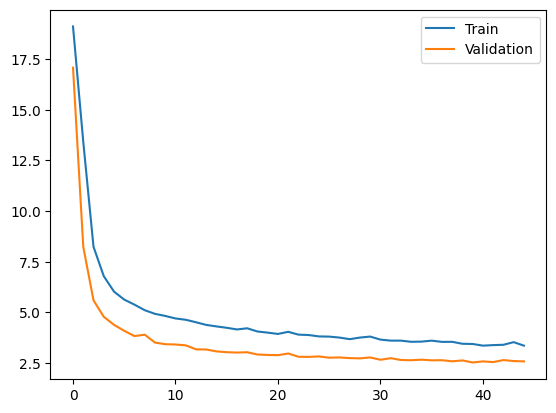

In [22]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()

### Тестирование модели (для упрощения - также на валидационных данных)

In [38]:
all_images = []
all_val_y = []

for i in tqdm(range(len(val_data_gen)), desc="Собираем данные"):
  (images, val_y, val_input_len, val_label_len), val_output = val_data_gen[i]

  all_images.append(images)
  all_val_y.append(val_y)

all_images = np.concatenate(all_images, axis=0)
all_val_y = np.concatenate(all_val_y, axis=0)

Собираем данные: 100%|██████████| 192/192 [02:13<00:00,  1.43it/s]


In [39]:
preds = model.predict(all_images)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(len(all_val_y)):
    prediction.append(num_to_label(decoded[i]))

765/765 [==============================] - 9s 11ms/step


In [47]:
y_val = val_df["translation"][:-1]

In [55]:
correct_char = 0
total_char = 0
correct = 0

for i in range(len(y_val)):
    pr = prediction[i]
    tr = str(y_val.iloc[i])
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(all_images)))

Correct characters predicted : 82.82%
Correct words predicted      : 62.14%
